## Sentiment Analysis using LSTM

Medha Sreenivasan-ms1112

Thwisha Nahender-tn130

In [25]:
#Importing the necessary libraries
import numpy as np
import matplotlib as pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
import string
import re
from keras.preprocessing.text import Tokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from string import punctuation


In [26]:
from google.colab import drive
drive.mount("/content/googledrive",force_remount=True)

Mounted at /content/googledrive


**IMDB Dataset**

In [ ]:
df=pd.read_csv("/content/googledrive/MyDrive/NLP Project/IMDB Dataset.csv")

In [ ]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
print("Shape of the dataset:", df.shape)

Shape of the dataset: (50000, 2)


## Data Preprocessing

In [ ]:
print(punctuation)


df['review'] = df['review'].str.lower()
df['review'] = df['review'].apply(lambda x: ''.join([c for c in x if c not in punctuation]))

# Split by new lines and spaces
df['review'] = df['review'].str.replace('\n', ' ')
df['review'] =df['review'].str.split()

# Create a list of words
df['review'] = df['review'].apply(lambda x: ' '.join(x))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
#Dataframe after preprocessing
df.head(10)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production br br the filmin...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive
5,probably my alltime favorite movie a story of ...,positive
6,i sure would like to see a resurrection of a u...,positive
7,this show was an amazing fresh innovative idea...,negative
8,encouraged by the positive comments about this...,negative
9,if you like original gut wrenching laughter yo...,positive


In [ ]:
reviews_split = df['review'].tolist()
labels_split = df['sentiment'].tolist()

## Tokenization

In [ ]:
reviews = df['review'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)

sequences = tokenizer.texts_to_sequences(reviews)


word_to_index = tokenizer.word_index


print("Dictionary: ", dict(list(word_to_index.items())[:5]))

Dictionary:  {'the': 1, 'and': 2, 'a': 3, 'of': 4, 'to': 5}


In [27]:
def tokenize_reviews(reviews_split, word_to_index):


    reviews_ints = []
    for review in reviews_split:
      reviews_ints.append([word_to_index[word] for word in review.split()])

    return reviews_ints

In [ ]:
reviews_ints = tokenize_reviews(reviews_split, word_to_index)

In [ ]:
print('Unique words: ', len((word_to_index)))
print()

print('Tokenized review: \n', reviews_ints[:1])

Unique words:  181685

Tokenized review: 
 [[28, 4, 1, 77, 1941, 44, 1063, 11, 100, 145, 40, 479, 3324, 393, 461, 26, 3190, 34, 23, 205, 14, 10, 6, 601, 48, 590, 15, 2137, 12, 1, 87, 146, 11, 3255, 69, 42, 3324, 13, 29, 5600, 2, 15378, 134, 4, 582, 61, 282, 7, 205, 35, 1, 670, 138, 1707, 69, 10, 6, 21, 3, 118, 16, 1, 8330, 5794, 39, 11861, 10, 118, 2508, 55, 6064, 15, 5636, 5, 1470, 381, 39, 582, 29, 6, 3407, 7, 1, 352, 340, 4, 1, 23503, 12, 8, 6, 469, 3324, 14, 11, 6, 1, 11516, 338, 5, 1, 16023, 6870, 2543, 1061, 61649, 8, 2637, 1375, 20, 25365, 536, 33, 4727, 2520, 4, 1, 1208, 112, 31, 1, 7153, 25, 2992, 13015, 2, 408, 61650, 37, 17529, 6, 21, 319, 20, 1, 5098, 3720, 536, 6, 344, 5, 81744, 8470, 41120, 15379, 5171, 7893, 2461, 2, 18404, 61651, 329, 9265, 7472, 13445, 2, 8721, 34936, 23, 109, 224, 5436, 12, 9, 57, 128, 1, 269, 1303, 4, 1, 118, 6, 668, 5, 1, 187, 11, 8, 262, 112, 77, 257, 548, 3001, 819, 178, 1271, 4349, 16, 2499, 1096, 819, 1412, 819, 81745, 148, 978, 181, 1, 87, 393,

In [ ]:
encoded_labels = np.array([1 if label == 'positive' else 0 for label in labels_split])

In [ ]:
# outlier review stats
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 0
Maximum review length: 2469


In [ ]:
print('Number of reviews before removing outliers: ', len(reviews_ints))

non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

# remove 0-length reviews and their labels
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(reviews_ints))

Number of reviews before removing outliers:  50000
Number of reviews after removing outliers:  50000


## Padding

In [28]:
def pad_features(reviews_ints, seq_length):


    features = np.zeros((len(reviews_ints), seq_length), dtype=int)


    for i, row in enumerate(reviews_ints):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

In [ ]:
seq_length = 200

features = pad_features(reviews_ints, seq_length=seq_length)


assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# printing first 10 values of the first 30 batches
print(features[:30,:10])

[[   28     4     1    77  1941    44  1063    11   100   145]
 [    3   384   115   358    12    12     1  1365  3015     6]
 [    9   194    10    13     3   384    98     5  1110    59]
 [  664   211     3   235   112     3   115   438  3554  1202]
 [81750 34937   110     7     1    59     4   291     6     3]
 [  234    53  3779   500    17     3    66     4 45600  4184]
 [    9   243    57    38     5    64     3  8960     4     3]
 [   10   118    13    33   488  1427  4082   313     7     1]
 [ 8471    32     1  1132   766    42    10    19    20   135]
 [   43    22    38   207  7529  9156  2209    22    76    38]
 [ 4482     1  1172     6    28     4   142  2578    95   112]
 [    9   201    10    17    50     9    13    42  1100    50]
 [   37   141    21     3   191   320     4 16024   163    18]
 [    1   179   248 25368    12  2195 12238    12     9  1074]
 [   10     3   793    17     4   279  3668    36   411   799]
 [  236     4  1537     7    32     1  2685   134    60

## Splitting data into train, valid and test

In [ ]:
split_frac = 0.8

# Splitting data into training, validation, and test data
train_idx = int(len(features) * split_frac)
train_x, remaining_x = features[:train_idx], features[train_idx:]
train_y, remaining_y = encoded_labels[:train_idx], encoded_labels[train_idx:]

test_val_idx = int(len(remaining_x) * 0.5)
val_idx = test_val_idx
test_idx = test_val_idx + int(len(remaining_x) * 0.5)

val_x, test_x = remaining_x[:val_idx], remaining_x[val_idx:test_idx]
val_y, test_y = remaining_y[:val_idx], remaining_y[val_idx:test_idx]


print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(40000, 200) 
Validation set: 	(5000, 200) 
Test set: 		(5000, 200)


In [ ]:
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,  drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
# one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size())
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[  10,    6,   28,  ...,    0,    0,    0],
        [  29,   52,  760,  ...,   59,    5, 1460],
        [  48,    3,  862,  ...,    0,    0,    0],
        ...,
        [ 120,  231,    1,  ..., 8780,    2,    9],
        [1319,   19,   15,  ...,    0,    0,    0],
        [ 862,   62,   52,  ...,   65,   31,  509]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0])


In [29]:
# checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


## LSTM Network Architecture

In [30]:
class SentimentLSTM(nn.Module):



    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):

        batch_size = x.size(0)

        x = x.long()

        # Embedding and LSTM layers
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out[:, -1, :]  # getting the last time step output

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)


        return sig_out, hidden

    def init_hidden(self, batch_size):

        # Created two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if torch.cuda.is_available():
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden


**Network Architecture**

embedding size = 128
hidden size = 128

In [ ]:
vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 128
hidden_dim = 128
n_layers = 2

net_2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_2)


lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=lr)

SentimentLSTM(
  (embedding): Embedding(181686, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


**Training**

In [ ]:
epochs = 20
counter = 0
print_every = 100
clip = 5

if train_on_gpu:
    net_2.cuda()

net_2.train()


for e in range(epochs):
    # initialize hidden state
    h = net_2.init_hidden(batch_size)


    for inputs, labels in train_loader:
        counter += 1

        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state
        h = tuple([each.data for each in h])

        output, h = net_2(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        net_2.zero_grad()

        # Backpropagation
        loss.backward()

        nn.utils.clip_grad_norm_(net_2.parameters(), clip)

        # Update weights
        optimizer.step()

        # loss stats
        if counter % print_every == 0:

            val_h = net_2.init_hidden(batch_size)
            val_losses = []
            correct = 0
            total = 0
            net_2.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state
                val_h = tuple([each.data for each in val_h])

                if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net_2(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())
                predicted = (output.squeeze() >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_acc = 100 * correct / total
            net_2.train()
            print("Epoch: {}/{}...".format(e + 1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
                  "Val Acc: {:.6f}".format(val_acc))


Epoch: 1/20... Step: 100... Loss: 0.697258... Val Loss: 0.693439 Val Acc: 49.940000
Epoch: 1/20... Step: 200... Loss: 0.679065... Val Loss: 0.693294 Val Acc: 50.520000
Epoch: 1/20... Step: 300... Loss: 0.720345... Val Loss: 0.686737 Val Acc: 53.380000
Epoch: 1/20... Step: 400... Loss: 0.682507... Val Loss: 0.691381 Val Acc: 52.980000
Epoch: 1/20... Step: 500... Loss: 0.682939... Val Loss: 0.686580 Val Acc: 53.120000
Epoch: 1/20... Step: 600... Loss: 0.686275... Val Loss: 0.687061 Val Acc: 54.560000
Epoch: 1/20... Step: 700... Loss: 0.690484... Val Loss: 0.693753 Val Acc: 50.780000
Epoch: 1/20... Step: 800... Loss: 0.703117... Val Loss: 0.692999 Val Acc: 50.860000
Epoch: 2/20... Step: 900... Loss: 0.700227... Val Loss: 0.692739 Val Acc: 50.860000
Epoch: 2/20... Step: 1000... Loss: 0.684843... Val Loss: 0.689211 Val Acc: 55.060000
Epoch: 2/20... Step: 1100... Loss: 0.692767... Val Loss: 0.693664 Val Acc: 50.120000
Epoch: 2/20... Step: 1200... Loss: 0.691976... Val Loss: 0.687023 Val Acc:

**Testing**

In [ ]:
test_losses = []
num_correct = 0


h = net_2.init_hidden(batch_size)

net_2.eval()

for inputs, labels in test_loader:

    # Creating new variables for the hidden state
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # getting predicted outputs
    output, h = net_2(inputs, h)

    # calculating loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())


    pred = torch.round(output.squeeze())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)



print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.760
Test accuracy: 0.837


**Network Architecture**

embedding size = 256
hidden size = 128

In [ ]:
vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 256
hidden_dim = 128
n_layers = 2

net_2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_2)


lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=lr)

SentimentLSTM(
  (embedding): Embedding(181686, 256)
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


**Training**

In [ ]:
epochs = 20
counter = 0
print_every = 100
clip = 5

if train_on_gpu:
    net_2.cuda()

net_2.train()


for e in range(epochs):
    # initialize hidden state
    h = net_2.init_hidden(batch_size)


    for inputs, labels in train_loader:
        counter += 1

        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state
        h = tuple([each.data for each in h])


        output, h = net_2(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        net_2.zero_grad()

        # Backpropagation
        loss.backward()

        nn.utils.clip_grad_norm_(net_2.parameters(), clip)

        # Update weights
        optimizer.step()

        # loss stats
        if counter % print_every == 0:

            val_h = net_2.init_hidden(batch_size)
            val_losses = []
            correct = 0
            total = 0
            net_2.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state
                val_h = tuple([each.data for each in val_h])

                if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net_2(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())
                predicted = (output.squeeze() >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_acc = 100 * correct / total
            net_2.train()
            print("Epoch: {}/{}...".format(e + 1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
                  "Val Acc: {:.6f}".format(val_acc))


Epoch: 1/20... Step: 100... Loss: 0.702825... Val Loss: 0.693006 Val Acc: 51.020000
Epoch: 1/20... Step: 200... Loss: 0.699039... Val Loss: 0.692240 Val Acc: 51.040000
Epoch: 1/20... Step: 300... Loss: 0.660628... Val Loss: 0.687799 Val Acc: 52.760000
Epoch: 1/20... Step: 400... Loss: 0.678751... Val Loss: 0.686601 Val Acc: 54.660000
Epoch: 1/20... Step: 500... Loss: 0.736670... Val Loss: 0.676845 Val Acc: 56.880000
Epoch: 1/20... Step: 600... Loss: 0.710945... Val Loss: 0.686574 Val Acc: 52.180000
Epoch: 1/20... Step: 700... Loss: 0.694582... Val Loss: 0.692845 Val Acc: 50.820000
Epoch: 1/20... Step: 800... Loss: 0.697468... Val Loss: 0.692918 Val Acc: 50.740000
Epoch: 2/20... Step: 900... Loss: 0.690885... Val Loss: 0.693234 Val Acc: 50.640000
Epoch: 2/20... Step: 1000... Loss: 0.695884... Val Loss: 0.693440 Val Acc: 50.180000
Epoch: 2/20... Step: 1100... Loss: 0.695883... Val Loss: 0.693824 Val Acc: 49.800000
Epoch: 2/20... Step: 1200... Loss: 0.693282... Val Loss: 0.693587 Val Acc:

**Testing**

In [ ]:
test_losses = []
num_correct = 0


h = net_2.init_hidden(batch_size)

net_2.eval()

for inputs, labels in test_loader:

    # Creating new variables for the hidden state
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    output, h = net_2(inputs, h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)



print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.965
Test accuracy: 0.829


**Network Architecture**

embedding size = 512
hidden size = 128

In [ ]:
vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 512
hidden_dim = 128
n_layers = 2

net_2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_2)


lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=lr)

SentimentLSTM(
  (embedding): Embedding(181686, 512)
  (lstm): LSTM(512, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


**Training**

In [ ]:
epochs = 20
counter = 0
print_every = 100
clip = 5

if train_on_gpu:
    net_2.cuda()

net_2.train()


for e in range(epochs):
    # initialize hidden state
    h = net_2.init_hidden(batch_size)


    for inputs, labels in train_loader:
        counter += 1

        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state
        h = tuple([each.data for each in h])


        output, h = net_2(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        net_2.zero_grad()

        # Backpropagation
        loss.backward()

        nn.utils.clip_grad_norm_(net_2.parameters(), clip)

        # Update weights
        optimizer.step()

        # loss stats
        if counter % print_every == 0:

            val_h = net_2.init_hidden(batch_size)
            val_losses = []
            correct = 0
            total = 0
            net_2.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state
                val_h = tuple([each.data for each in val_h])

                if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net_2(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())
                predicted = (output.squeeze() >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_acc = 100 * correct / total
            net_2.train()
            print("Epoch: {}/{}...".format(e + 1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
                  "Val Acc: {:.6f}".format(val_acc))


Epoch: 1/20... Step: 100... Loss: 0.694617... Val Loss: 0.692430 Val Acc: 51.300000
Epoch: 1/20... Step: 200... Loss: 0.683371... Val Loss: 0.686519 Val Acc: 54.560000
Epoch: 1/20... Step: 300... Loss: 0.663677... Val Loss: 0.692235 Val Acc: 49.260000
Epoch: 1/20... Step: 400... Loss: 0.635425... Val Loss: 0.643771 Val Acc: 63.820000
Epoch: 1/20... Step: 500... Loss: 0.674976... Val Loss: 0.662361 Val Acc: 64.500000
Epoch: 1/20... Step: 600... Loss: 0.675596... Val Loss: 0.640696 Val Acc: 66.420000
Epoch: 1/20... Step: 700... Loss: 0.749199... Val Loss: 0.713838 Val Acc: 51.880000
Epoch: 1/20... Step: 800... Loss: 0.517092... Val Loss: 0.605780 Val Acc: 67.040000
Epoch: 2/20... Step: 900... Loss: 0.401648... Val Loss: 0.587018 Val Acc: 73.180000
Epoch: 2/20... Step: 1000... Loss: 0.377664... Val Loss: 0.536553 Val Acc: 76.580000
Epoch: 2/20... Step: 1100... Loss: 0.625742... Val Loss: 0.496142 Val Acc: 77.540000
Epoch: 2/20... Step: 1200... Loss: 0.557960... Val Loss: 0.531953 Val Acc:

**Testing**

In [ ]:
test_losses = []
num_correct = 0


h = net_2.init_hidden(batch_size)

net_2.eval()

for inputs, labels in test_loader:

    # Creating new variables for the hidden state
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    output, h = net_2(inputs, h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)



print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.980
Test accuracy: 0.842


**Network Architecture**

embedding size = 128
hidden size = 256

In [ ]:
vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 128
hidden_dim = 256
n_layers = 2

net_2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_2)


lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=lr)

SentimentLSTM(
  (embedding): Embedding(181686, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
def train_lstm(net_2):
  epochs = 15
  counter = 0
  print_every = 100
  clip = 5

  if train_on_gpu:
      net_2.cuda()

  net_2.train()

  for e in range(epochs):
      # initialize hidden state
      h = net_2.init_hidden(batch_size)


      for inputs, labels in train_loader:
          counter += 1

          if train_on_gpu:
              inputs, labels = inputs.cuda(), labels.cuda()

          # Creating new variables for the hidden state
          h = tuple([each.data for each in h])


          output, h = net_2(inputs, h)

          loss = criterion(output.squeeze(), labels.float())
          net_2.zero_grad()

          # Backpropagation
          loss.backward()

          nn.utils.clip_grad_norm_(net_2.parameters(), clip)

          # Update weights
          optimizer.step()

          # loss stats
          if counter % print_every == 0:

              val_h = net_2.init_hidden(batch_size)
              val_losses = []
              correct = 0
              total = 0
              net_2.eval()
              for inputs, labels in valid_loader:

                  # Creating new variables for the hidden state
                  val_h = tuple([each.data for each in val_h])

                  if train_on_gpu:
                      inputs, labels = inputs.cuda(), labels.cuda()

                  output, val_h = net_2(inputs, val_h)
                  val_loss = criterion(output.squeeze(), labels.float())

                  val_losses.append(val_loss.item())
                  predicted = (output.squeeze() >= 0.5).float()
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

              val_acc = 100 * correct / total
              net_2.train()
              print("Epoch: {}/{}...".format(e + 1, epochs),
                    "Step: {}...".format(counter),
                    "Loss: {:.6f}...".format(loss.item()),
                    "Val Loss: {:.6f}".format(np.mean(val_losses)),
                    "Val Acc: {:.6f}".format(val_acc))
  return net_2


**Training**

In [ ]:
net_2 = train_lstm(net_2)

Epoch: 1/15... Step: 100... Loss: 0.688641... Val Loss: 0.693799 Val Acc: 50.220000
Epoch: 1/15... Step: 200... Loss: 0.687708... Val Loss: 0.691927 Val Acc: 50.680000
Epoch: 1/15... Step: 300... Loss: 0.684072... Val Loss: 0.693244 Val Acc: 50.900000
Epoch: 1/15... Step: 400... Loss: 0.685174... Val Loss: 0.698042 Val Acc: 49.440000
Epoch: 1/15... Step: 500... Loss: 0.699803... Val Loss: 0.693066 Val Acc: 50.300000
Epoch: 1/15... Step: 600... Loss: 0.693471... Val Loss: 0.693275 Val Acc: 50.160000
Epoch: 1/15... Step: 700... Loss: 0.693082... Val Loss: 0.693078 Val Acc: 50.740000
Epoch: 1/15... Step: 800... Loss: 0.694457... Val Loss: 0.694196 Val Acc: 49.260000
Epoch: 2/15... Step: 900... Loss: 0.695498... Val Loss: 0.692015 Val Acc: 52.160000
Epoch: 2/15... Step: 1000... Loss: 0.687206... Val Loss: 0.689434 Val Acc: 53.260000
Epoch: 2/15... Step: 1100... Loss: 0.679238... Val Loss: 0.670346 Val Acc: 59.800000
Epoch: 2/15... Step: 1200... Loss: 0.696126... Val Loss: 0.699625 Val Acc:

**Testing**

In [ ]:
test_losses = []
num_correct = 0

h = net_2.init_hidden(batch_size)

net_2.eval()

for inputs, labels in test_loader:

    # Creating new variables for the hidden state
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    output, h = net_2(inputs, h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)



print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.765
Test accuracy: 0.844


**Network Architecture**

embedding dim = 256
hidden dim = 256

In [ ]:
vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 256
hidden_dim = 256
n_layers = 2

net_2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_2)


lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=lr)

SentimentLSTM(
  (embedding): Embedding(181686, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


**Training**

In [ ]:
net_2 = train_lstm(net_2)

Epoch: 1/15... Step: 100... Loss: 0.688169... Val Loss: 0.703493 Val Acc: 49.820000
Epoch: 1/15... Step: 200... Loss: 0.689537... Val Loss: 0.693383 Val Acc: 49.540000
Epoch: 1/15... Step: 300... Loss: 0.696504... Val Loss: 0.691002 Val Acc: 52.320000
Epoch: 1/15... Step: 400... Loss: 0.686226... Val Loss: 0.693581 Val Acc: 49.760000
Epoch: 1/15... Step: 500... Loss: 0.690426... Val Loss: 0.688194 Val Acc: 55.600000
Epoch: 1/15... Step: 600... Loss: 0.679649... Val Loss: 0.688669 Val Acc: 55.160000
Epoch: 1/15... Step: 700... Loss: 0.693482... Val Loss: 0.694542 Val Acc: 49.260000
Epoch: 1/15... Step: 800... Loss: 0.691703... Val Loss: 0.692834 Val Acc: 51.420000
Epoch: 2/15... Step: 900... Loss: 0.692418... Val Loss: 0.693024 Val Acc: 50.180000
Epoch: 2/15... Step: 1000... Loss: 0.694951... Val Loss: 0.692768 Val Acc: 50.740000
Epoch: 2/15... Step: 1100... Loss: 0.685779... Val Loss: 0.693102 Val Acc: 50.740000
Epoch: 2/15... Step: 1200... Loss: 0.689038... Val Loss: 0.692941 Val Acc:

In [ ]:
def test_lstm(net_2):
  test_losses = []
  num_correct = 0

  h = net_2.init_hidden(batch_size)

  net_2.eval()

  for inputs, labels in test_loader:

    # Creating new variables for the hidden state
      h = tuple([each.data for each in h])

      if(train_on_gpu):
          inputs, labels = inputs.cuda(), labels.cuda()

      # get predicted outputs
      output, h = net_2(inputs, h)

      # calculate loss
      test_loss = criterion(output.squeeze(), labels.float())
      test_losses.append(test_loss.item())

      # convert output probabilities to predicted class (0 or 1)
      pred = torch.round(output.squeeze())

      # compare predictions to true label
      correct_tensor = pred.eq(labels.float().view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      num_correct += np.sum(correct)



  print("Test loss: {:.3f}".format(np.mean(test_losses)))

  # accuracy over all test data
  test_acc = num_correct/len(test_loader.dataset)
  print("Test accuracy: {:.3f}".format(test_acc))

**Testing**

In [ ]:
test_lstm(net_2)

Test loss: 0.778
Test accuracy: 0.853


**Network Architecture**

embedding dim = 512
hidden dim = 256

In [ ]:
vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 512
hidden_dim = 256
n_layers = 2

net_2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_2)


lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=lr)

SentimentLSTM(
  (embedding): Embedding(181686, 512)
  (lstm): LSTM(512, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


**Training**

In [ ]:
net_2 = train_lstm(net_2)

Epoch: 1/15... Step: 100... Loss: 0.690232... Val Loss: 0.691173 Val Acc: 52.220000
Epoch: 1/15... Step: 200... Loss: 0.680128... Val Loss: 0.692224 Val Acc: 51.600000
Epoch: 1/15... Step: 300... Loss: 0.688243... Val Loss: 0.686119 Val Acc: 54.820000
Epoch: 1/15... Step: 400... Loss: 0.680807... Val Loss: 0.682196 Val Acc: 54.540000
Epoch: 1/15... Step: 500... Loss: 0.742827... Val Loss: 0.701086 Val Acc: 50.440000
Epoch: 1/15... Step: 600... Loss: 0.701749... Val Loss: 0.692566 Val Acc: 51.560000
Epoch: 1/15... Step: 700... Loss: 0.699174... Val Loss: 0.694463 Val Acc: 50.420000
Epoch: 1/15... Step: 800... Loss: 0.708339... Val Loss: 0.692744 Val Acc: 49.880000
Epoch: 2/15... Step: 900... Loss: 0.702561... Val Loss: 0.691625 Val Acc: 52.600000
Epoch: 2/15... Step: 1000... Loss: 0.679512... Val Loss: 0.684286 Val Acc: 55.560000
Epoch: 2/15... Step: 1100... Loss: 0.697731... Val Loss: 0.691431 Val Acc: 56.100000
Epoch: 2/15... Step: 1200... Loss: 0.645320... Val Loss: 0.659991 Val Acc:

**Testing**

In [ ]:
test_lstm(net_2)

Test loss: 0.834
Test accuracy: 0.840


**Network Architecture**

embedding dim = 128
hidden dim = 512

In [ ]:
vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 128
hidden_dim = 512
n_layers = 2

net_2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_2)


lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=lr)

SentimentLSTM(
  (embedding): Embedding(181686, 128)
  (lstm): LSTM(128, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)


**Training**

In [ ]:
net_2 = train_lstm(net_2)

Epoch: 1/15... Step: 100... Loss: 0.703893... Val Loss: 0.695486 Val Acc: 50.580000
Epoch: 1/15... Step: 200... Loss: 0.693262... Val Loss: 0.693971 Val Acc: 49.260000
Epoch: 1/15... Step: 300... Loss: 0.673590... Val Loss: 0.699349 Val Acc: 49.260000
Epoch: 1/15... Step: 400... Loss: 0.691551... Val Loss: 0.693069 Val Acc: 49.780000
Epoch: 1/15... Step: 500... Loss: 0.693744... Val Loss: 0.692636 Val Acc: 51.380000
Epoch: 1/15... Step: 600... Loss: 0.698308... Val Loss: 0.693778 Val Acc: 49.680000
Epoch: 1/15... Step: 700... Loss: 0.690110... Val Loss: 0.691875 Val Acc: 51.840000
Epoch: 1/15... Step: 800... Loss: 0.700661... Val Loss: 0.692756 Val Acc: 50.360000
Epoch: 2/15... Step: 900... Loss: 0.682380... Val Loss: 0.689403 Val Acc: 52.720000
Epoch: 2/15... Step: 1000... Loss: 0.680868... Val Loss: 0.716620 Val Acc: 49.260000
Epoch: 2/15... Step: 1100... Loss: 0.694885... Val Loss: 0.694184 Val Acc: 50.640000
Epoch: 2/15... Step: 1200... Loss: 0.692475... Val Loss: 0.693155 Val Acc:

**Network Architecture**

embedding dim = 256
hidden dim = 512

In [ ]:
vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 256
hidden_dim = 512
n_layers = 2

net_2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_2)


lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=lr)

SentimentLSTM(
  (embedding): Embedding(181686, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)


**Training**

In [ ]:
net_2 = train_lstm(net_2)

Epoch: 1/15... Step: 100... Loss: 0.708381... Val Loss: 0.691819 Val Acc: 52.360000
Epoch: 1/15... Step: 200... Loss: 0.694353... Val Loss: 0.691338 Val Acc: 51.900000
Epoch: 1/15... Step: 300... Loss: 0.721463... Val Loss: 0.699789 Val Acc: 50.140000
Epoch: 1/15... Step: 400... Loss: 0.702218... Val Loss: 0.699755 Val Acc: 50.020000
Epoch: 1/15... Step: 500... Loss: 0.711733... Val Loss: 0.695870 Val Acc: 50.740000
Epoch: 1/15... Step: 600... Loss: 0.691102... Val Loss: 0.693204 Val Acc: 50.100000
Epoch: 1/15... Step: 700... Loss: 0.674386... Val Loss: 0.695389 Val Acc: 49.840000
Epoch: 1/15... Step: 800... Loss: 0.697794... Val Loss: 0.693075 Val Acc: 50.480000
Epoch: 2/15... Step: 900... Loss: 0.695721... Val Loss: 0.693128 Val Acc: 50.140000
Epoch: 2/15... Step: 1000... Loss: 0.694018... Val Loss: 0.694723 Val Acc: 49.260000
Epoch: 2/15... Step: 1100... Loss: 0.692125... Val Loss: 0.693200 Val Acc: 50.080000
Epoch: 2/15... Step: 1200... Loss: 0.695096... Val Loss: 0.693021 Val Acc:

**Network Architecture**

embedding dim = 512
hidden dim = 512

In [ ]:
vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 512
hidden_dim = 512
n_layers = 2

net_2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_2)


lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=lr)

SentimentLSTM(
  (embedding): Embedding(181686, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)


**Training**

In [ ]:
net_2 = train_lstm(net_2)

Epoch: 1/15... Step: 100... Loss: 0.690307... Val Loss: 0.692677 Val Acc: 50.420000
Epoch: 1/15... Step: 200... Loss: 0.678484... Val Loss: 0.687587 Val Acc: 53.400000
Epoch: 1/15... Step: 300... Loss: 0.699270... Val Loss: 0.682307 Val Acc: 59.500000
Epoch: 1/15... Step: 400... Loss: 0.698131... Val Loss: 0.690434 Val Acc: 53.860000
Epoch: 1/15... Step: 500... Loss: 0.698116... Val Loss: 0.681058 Val Acc: 54.800000
Epoch: 1/15... Step: 600... Loss: 0.645769... Val Loss: 0.658957 Val Acc: 58.780000
Epoch: 1/15... Step: 700... Loss: 0.458977... Val Loss: 0.606260 Val Acc: 71.000000
Epoch: 1/15... Step: 800... Loss: 0.501150... Val Loss: 0.499541 Val Acc: 77.200000
Epoch: 2/15... Step: 900... Loss: 0.468834... Val Loss: 0.490180 Val Acc: 75.700000
Epoch: 2/15... Step: 1000... Loss: 0.491324... Val Loss: 0.442329 Val Acc: 81.300000
Epoch: 2/15... Step: 1100... Loss: 0.341583... Val Loss: 0.449092 Val Acc: 80.260000
Epoch: 2/15... Step: 1200... Loss: 0.271244... Val Loss: 0.440328 Val Acc:

#### train model for predictions


In [ ]:
vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 512
hidden_dim = 512
n_layers = 2

net_2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_2)


lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=lr)

SentimentLSTM(
  (embedding): Embedding(181686, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
epochs = 20
counter = 0
print_every = 100
clip = 5

if train_on_gpu:
    net_2.cuda()

net_2.train()
best_val_acc = 0
epoch_losses = []

for e in range(epochs):
    # initialize hidden state
    h = net_2.init_hidden(batch_size)


    for inputs, labels in train_loader:
        counter += 1

        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state
        h = tuple([each.data for each in h])


        output, h = net_2(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        net_2.zero_grad()

        # Backpropagation
        loss.backward()

        nn.utils.clip_grad_norm_(net_2.parameters(), clip)

        # Update weights
        optimizer.step()

        # loss stats
        if counter % print_every == 0:

            val_h = net_2.init_hidden(batch_size)
            val_losses = []
            correct = 0
            total = 0
            net_2.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state
                val_h = tuple([each.data for each in val_h])

                if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net_2(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())
                predicted = (output.squeeze() >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_acc = 100 * correct / total
            epoch_losses.append(val_acc)
            net_2.train()
            print("Epoch: {}/{}...".format(e + 1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
                  "Val Acc: {:.6f}".format(val_acc))
            if val_acc > best_val_acc:
              best_val_acc = val_acc

              # Save the model
              checkpoint = {
                  'state_dict': net_2.state_dict(),
                  'best_val_acc': best_val_acc,
                  'optimizer': optimizer.state_dict(),
                  'epoch': e
              }
              torch.save(checkpoint, 'best_model.pth')

              print("Model saved with higher validation accuracy: {:.6f}".format(best_val_acc))


Epoch: 1/20... Step: 100... Loss: 0.688842... Val Loss: 0.689447 Val Acc: 52.400000
Model saved with higher validation accuracy: 52.400000
Epoch: 1/20... Step: 200... Loss: 0.663496... Val Loss: 0.727650 Val Acc: 50.820000
Epoch: 1/20... Step: 300... Loss: 0.694687... Val Loss: 0.689579 Val Acc: 53.040000
Model saved with higher validation accuracy: 53.040000
Epoch: 1/20... Step: 400... Loss: 0.705066... Val Loss: 0.697330 Val Acc: 49.260000
Epoch: 1/20... Step: 500... Loss: 0.684458... Val Loss: 0.692753 Val Acc: 50.780000
Epoch: 1/20... Step: 600... Loss: 0.695380... Val Loss: 0.676613 Val Acc: 61.620000
Model saved with higher validation accuracy: 61.620000
Epoch: 1/20... Step: 700... Loss: 0.688416... Val Loss: 0.694151 Val Acc: 49.280000
Epoch: 1/20... Step: 800... Loss: 0.690874... Val Loss: 0.693174 Val Acc: 49.340000
Epoch: 2/20... Step: 900... Loss: 0.681359... Val Loss: 0.691504 Val Acc: 51.140000
Epoch: 2/20... Step: 1000... Loss: 0.625029... Val Loss: 0.635315 Val Acc: 69.2

In [58]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
vocab_size = len(word_to_index)+1
output_size = 1
embedding_dim = 512
hidden_dim = 512
n_layers = 2

net_2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net_2)


lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_2.parameters(), lr=lr)

# Load the saved model state
checkpoint = torch.load('best_model.pth')
net_2.load_state_dict(checkpoint['state_dict'])

SentimentLSTM(
  (embedding): Embedding(181686, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)


<All keys matched successfully>

In [ ]:

test_losses = []
num_correct = 0
test_predictions = []
h = net_2.init_hidden(batch_size)
f1_scores = []
recalls = []
precisions = []

net_2.eval()

for inputs, labels in test_loader:

  # Creating new variables for the hidden state
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
        net_2.cuda()

    # get predicted outputs
    output, h = net_2(inputs, h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    ## compute the f1 score
    f1_scores.append(f1_score(labels.cpu().detach().numpy(),pred.cpu().detach().numpy()))
    recalls.append(recall_score(labels.cpu().detach().numpy(),pred.cpu().detach().numpy()))
    precisions.append(precision_score(labels.cpu().detach().numpy(),pred.cpu().detach().numpy()))
    ## compute the recall
    ## compute precision




print("Test loss: {:.3f}".format(np.mean(test_losses)))
print("F1 score:",np.mean(f1_scores))
print("Recall:",np.mean(recalls))
print("precisions:",np.mean(precisions))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.468
F1 score: 0.8600469292239535
Recall: 0.8699571805623154
precisions: 0.8549720679413203
Test accuracy: 0.863


In [ ]:
epochs = np.arange(1,161)
actual_e = epochs/8

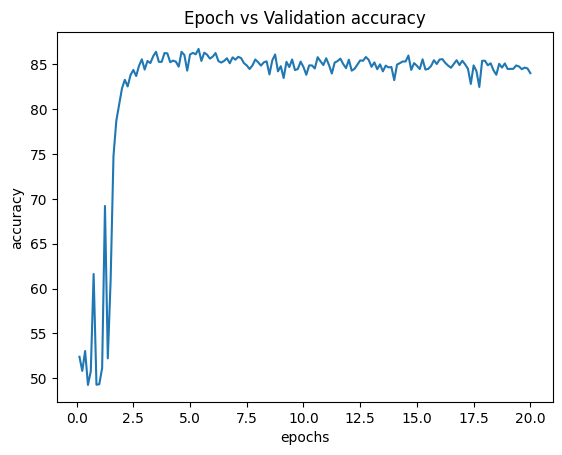

In [ ]:
import matplotlib.pyplot as plt
plt.plot(actual_e, np.array(epoch_losses))
plt.title('Epoch vs Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [44]:
def tokenize_review(test_review):
    test_review = test_review.lower() # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_review if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    test_ints.append([word_to_index_synthetic.get(word, 0) for word in test_words])

    return test_ints


In [45]:
def predict(net, test_review, sequence_length=200):

    net.eval()

    # tokenize review
    test_ints = tokenize_review(test_review)

    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)

    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)

    batch_size = feature_tensor.size(0)

    # initialize hidden state
    h = net.init_hidden(batch_size)

    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()

    # get the output from the model
    output, h = net(feature_tensor, h)

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))

    # print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")

In [ ]:
test_review_pos = 'The Hunger Games: The Ballad Of Songbirds & Snakes is the perfect masterpiece haunting origin tale showing the downfall of president snow. What a masterful job at taking the book and adapting it to the screen. The cinematography is excellent.'

In [ ]:
# call function
seq_length=200

predict(net_2, test_review_pos, seq_length)

Prediction value, pre-rounding: 0.999517
Positive review detected!


In [ ]:
my_review='Good movie'

In [ ]:
seq_length=200

predict(net_2, my_review, seq_length)

Prediction value, pre-rounding: 0.993136
Positive review detected!


In [ ]:
# call function
seq_length=200

predict(net_2, "I enjoyed the movie!", seq_length)

Prediction value, pre-rounding: 0.970758
Positive review detected!


In [ ]:
# call function
seq_length=200

predict(net_2, "I hated the acting and the plot!", seq_length)

Prediction value, pre-rounding: 0.082474
Negative review detected.


In [ ]:
# call function
seq_length=200

predict(net_2, "i did not love the vibrant colors in the movie", seq_length)

Prediction value, pre-rounding: 0.064976
Negative review detected.


## Training with Synthetic dataset

In [31]:
df_synthetic=pd.read_csv("/content/googledrive/MyDrive/NLP Project/synthetic_data.csv")
df_synthetic.head(10)

,review,label
0,hickok see perfect overhead man pretentious r...,1
1,high film idea problem even bush porn helping...,0
2,grave one supposed message make audience mixe...,0
3,another clear novelist film solitude movie wi...,1
4,book standard smart energy drowning show mess...,1
5,offend actually acting bloody future narrowly...,1
6,exploit niro polled coyote costume favorite k...,1
7,almost good must movie one still jerk since i...,0
8,mystery see movie exit lovable ironic monkey ...,0
9,using film friend system would film photoserv...,1


In [32]:
print("Shape of synthetic dataset", df_synthetic.shape)

Shape of synthetic dataset (1000, 2)


In [33]:
print(punctuation)

# Get rid of punctuation
df_synthetic['review'] = df_synthetic['review'].str.lower()
df_synthetic['review'] = df_synthetic['review'].apply(lambda x: ''.join([c for c in x if c not in punctuation]))

# Split by new lines and spaces
df_synthetic['review'] = df_synthetic['review'].str.replace('\n', ' ')
df_synthetic['review'] =df_synthetic['review'].str.split()

# Create a list of words
df_synthetic['review'] = df_synthetic['review'].apply(lambda x: ' '.join(x))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [34]:
def tokenize(df_column):


    reviews = df_column.values

    # Tokenize the reviews
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(reviews)
    sequences = tokenizer.texts_to_sequences(reviews)

    # Get the dictionary
    word_to_index = tokenizer.word_index


    print("Dictionary: ", dict(list(word_to_index.items())[:5]))

    return tokenizer, sequences, word_to_index

In [35]:
tokenizer_synthetic, sequences_synthetic, word_to_index_synthetic = tokenize(df_synthetic['review'])

Dictionary:  {'movie': 1, 'film': 2, 'one': 3, 'like': 4, 'good': 5}


In [36]:
reviews_split_synthetic = df_synthetic['review'].tolist()
labels_split_synthetic= df_synthetic['label'].tolist()

In [37]:
encoded_labels=np.array(labels_split_synthetic)

In [38]:
reviews_ints_synthetic = tokenize_reviews(reviews_split_synthetic, word_to_index_synthetic)

In [39]:

seq_length = 200

features_synthetic = pad_features(reviews_ints_synthetic, seq_length=seq_length)


assert len(features_synthetic)==len(reviews_ints_synthetic), "Your features should have as many rows as reviews."
assert len(features_synthetic[0])==seq_length, "Each feature row should contain seq_length values."


print(features_synthetic[:30,:10])

[[7977   12  314 4064   51 1240 1615 1403  389  958]
 [ 227    2  153  173    9 2824 1076 1779    3  611]
 [2450    3  273  463   10  177 1781 4070  411  770]
 [  63  563 4074    2 5292    1 4075   83    1 7998]
 [ 148  822  857 1498 4083   24  637  206 8003 8004]
 [5296   70   45 1619  736 8007    3 8008 8009   11]
 [4091 5301 8017 5302  614  315  137  281   68   80]
 [ 133    5   91    1    3   53 2833  136  362 1785]
 [ 505   12    1 4095 1788 2458 1079   10    2   71]
 [ 775    2  112 2459    8    2 8034 8035  117   20]
 [2190  411   24 3349 8038 1965 8039  369 8040 2196]
 [1330  800  159  105 8051  190 8052 3352  174 2203]
 [4106 1628 1248 1333 4107 1413 8061  329  212 5313]
 [ 206  663  281   33 8076   36 5316 1972 1794   32]
 [   6 8083  112 1504   54 1161   42 4114  301   20]
 [  15 4118  866   33 4119    3 3357 4120   17    2]
 [ 259  190 5326  150  160 4123  740 1164  711    1]
 [5329 8105 8106  216  306  306   43 8107 8108  365]
 [1339  708 5345 1257   26 8129 1258  206   71

In [40]:
split_frac = 0.8

# Split data into training, validation, and test data
train_idx = int(len(features_synthetic) * split_frac)
train_x, remaining_x = features_synthetic[:train_idx], features_synthetic[train_idx:]
train_y, remaining_y = encoded_labels[:train_idx], encoded_labels[train_idx:]

test_val_idx = int(len(remaining_x) * 0.5)
val_idx = test_val_idx
test_idx = test_val_idx + int(len(remaining_x) * 0.5)

val_x, test_x = remaining_x[:val_idx], remaining_x[val_idx:test_idx]
val_y, test_y = remaining_y[:val_idx], remaining_y[val_idx:test_idx]


print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(800, 200) 
Validation set: 	(100, 200) 
Test set: 		(100, 200)


In [41]:
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,  drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [42]:
vocab_size = len(word_to_index_synthetic)+1
output_size = 1
embedding_dim = 512
hidden_dim = 512
n_layers = 2

net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
checkpoint = torch.load('/content/googledrive/MyDrive/NLP Project/best_model_synthetic.pth', map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['state_dict'])

SentimentLSTM(
  (embedding): Embedding(17796, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)


<All keys matched successfully>

In [59]:

test_losses = []
num_correct = 0
test_predictions = []
h = net.init_hidden(batch_size)
f1_scores = []
recalls = []
precisions = []

net.eval()

for inputs, labels in test_loader:

  # Creating new variables for the hidden state
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
        net.cuda()

    # get predicted outputs
    output, h = net(inputs, h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    ## compute the f1 score
    f1_scores.append(f1_score(labels.cpu().detach().numpy(),pred.cpu().detach().numpy()))
    recalls.append(recall_score(labels.cpu().detach().numpy(),pred.cpu().detach().numpy()))
    precisions.append(precision_score(labels.cpu().detach().numpy(),pred.cpu().detach().numpy()))
    ## compute the recall
    ## compute precision




print("Test loss: {:.3f}".format(np.mean(test_losses)))
print("F1 score:",np.mean(f1_scores))
print("Recall:",np.mean(recalls))
print("precisions:",np.mean(precisions))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.747
F1 score: 0.4657849338700403
Recall: 0.37962962962962965
precisions: 0.6595238095238095
Test accuracy: 0.560


In [47]:
# call function
seq_length=200

predict(net, "I enjoyed the movie!", seq_length)

Prediction value, pre-rounding: 0.505942
Positive review detected!


In [55]:
# call function
seq_length=200

predict(net, "Horrible movie", seq_length)

Prediction value, pre-rounding: 0.497262
Negative review detected.


In [51]:
# call function
seq_length=200

predict(net, "i did not love the vibrant colors in the movie", seq_length)

Prediction value, pre-rounding: 0.509269
Positive review detected!
